# Semantic Segmentation Project

In [1]:
!pip install tqdm

You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import os.path
import tensorflow as tf
import helper
import warnings
from distutils.version import LooseVersion
import project_tests as tests


# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


In [3]:
def load_vgg(sess, vgg_path):
    """
    Load Pretrained VGG Model into TensorFlow.
    :param sess: TensorFlow Session
    :param vgg_path: Path to vgg folder, containing "variables/" and "saved_model.pb"
    :return: Tuple of Tensors from VGG model (image_input, keep_prob, layer3_out, layer4_out, layer7_out)
    """
    # TODO: Implement function
    #   Use tf.saved_model.loader.load to load the model and weights
    vgg_tag = 'vgg16'
    vgg_input_tensor_name = 'image_input:0'
    vgg_keep_prob_tensor_name = 'keep_prob:0'
    vgg_layer3_out_tensor_name = 'layer3_out:0'
    vgg_layer4_out_tensor_name = 'layer4_out:0'
    vgg_layer7_out_tensor_name = 'layer7_out:0'
    #Get the saved model
    tf.saved_model.loader.load(sess, [vgg_tag], vgg_path)
    graph = tf.get_default_graph()
    #Get input layer and keep prob parameter
    layer0 = graph.get_tensor_by_name(vgg_input_tensor_name)
    keep_prob = graph.get_tensor_by_name(vgg_keep_prob_tensor_name)
    #Get the rest of the layers
    layer3 = graph.get_tensor_by_name(vgg_layer3_out_tensor_name)
    layer4 = graph.get_tensor_by_name(vgg_layer4_out_tensor_name)
    layer7 = graph.get_tensor_by_name(vgg_layer7_out_tensor_name)

    return layer0, keep_prob, layer3, layer4, layer7

tests.test_load_vgg(load_vgg, tf)

Tests Passed


In [4]:
def layers(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out, num_classes):
    """
    Create the layers for a fully convolutional network.  Build skip-layers using the vgg layers.
    :param vgg_layer3_out: TF Tensor for VGG Layer 3 output
    :param vgg_layer4_out: TF Tensor for VGG Layer 4 output
    :param vgg_layer7_out: TF Tensor for VGG Layer 7 output
    :param num_classes: Number of classes to classify
    :return: The Tensor for the last layer of output
    """
    # TODO: Implement function
    weights_initializer_stddev = 1e-2
    weights_regularized_l2 = 1e-3
    # 1x1 Convolutions to preserve spatial information that would 
    # be lost if kept the fully connected layers.
    conv_1x1_of_7 = tf.layers.conv2d(vgg_layer7_out,
                                     num_classes,
                                     1, # kernel_size
                                     padding = 'same',
                                     kernel_initializer = tf.random_normal_initializer(stddev=weights_initializer_stddev),
                                     kernel_regularizer= tf.contrib.layers.l2_regularizer(weights_regularized_l2),
                                     name='conv_1x1_of_7')
    # Upsample deconvolution x 2
    first_upsamplex2 = tf.layers.conv2d_transpose(conv_1x1_of_7,
                                                  num_classes,
                                                  4, # kernel_size
                                                  strides= (2, 2),
                                                  padding= 'same',
                                                  kernel_initializer = tf.random_normal_initializer(stddev=weights_initializer_stddev),
                                                  kernel_regularizer= tf.contrib.layers.l2_regularizer(weights_regularized_l2),
                                                  name='first_upsamplex2')
    conv_1x1_of_4 = tf.layers.conv2d(vgg_layer4_out,
                                     num_classes,
                                     1, # kernel_size
                                     padding = 'same',
                                     kernel_initializer = tf.random_normal_initializer(stddev=weights_initializer_stddev),
                                     kernel_regularizer= tf.contrib.layers.l2_regularizer(weights_regularized_l2),
                                     name='conv_1x1_of_4')
    # Adding skip layer.
    first_skip = tf.add(first_upsamplex2, conv_1x1_of_4, name='first_skip')
    # Upsample deconvolutions x 2.
    second_upsamplex2 = tf.layers.conv2d_transpose(first_skip,
                                                   num_classes,
                                                   4, # kernel_size
                                                   strides= (2, 2),
                                                   padding= 'same',
                                                   kernel_initializer = tf.random_normal_initializer(stddev=weights_initializer_stddev),
                                                   kernel_regularizer= tf.contrib.layers.l2_regularizer(weights_regularized_l2),
                                                   name='second_upsamplex2')
    conv_1x1_of_3 = tf.layers.conv2d(vgg_layer3_out,
                                     num_classes,
                                     1, # kernel_size
                                     padding = 'same',
                                     kernel_initializer = tf.random_normal_initializer(stddev=weights_initializer_stddev),
                                     kernel_regularizer= tf.contrib.layers.l2_regularizer(weights_regularized_l2),
                                     name='conv_1x1_of_3')
    # Adding skip layer.
    second_skip = tf.add(second_upsamplex2, conv_1x1_of_3, name='second_skip')
    # Upsample deconvolution x 8.
    third_upsamplex8 = tf.layers.conv2d_transpose(second_skip, num_classes, 16,
                                                  strides= (8, 8),
                                                  padding= 'same',
                                                  kernel_initializer = tf.random_normal_initializer(stddev=weights_initializer_stddev),
                                                  kernel_regularizer= tf.contrib.layers.l2_regularizer(weights_regularized_l2),
                                                  name='third_upsamplex8')
    return third_upsamplex8
tests.test_layers(layers)


Tests Passed


In [5]:
def optimize(nn_last_layer, correct_label, learning_rate, num_classes):
    """
    Build the TensorFLow loss and optimizer operations.
    :param nn_last_layer: TF Tensor of the last layer in the neural network
    :param correct_label: TF Placeholder for the correct label image
    :param learning_rate: TF Placeholder for the learning rate
    :param num_classes: Number of classes to classify
    :return: Tuple of (logits, train_op, cross_entropy_loss)
    """
    # TODO: Implement function
    # create logits : 2D tensor where each row represents a pixel and each column a class.
    logits = tf.reshape(nn_last_layer, (-1, num_classes))
    correct_label = tf.reshape(correct_label, (-1, num_classes))
    # create loss function.
    cross_entropy_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits= logits, labels= correct_label))
    # Define optimizer. Adam in this case to have variable learning rate.
    optimizer = tf.train.AdamOptimizer(learning_rate= learning_rate)
    # Apply optimizer to the loss function.
    train_op = optimizer.minimize(cross_entropy_loss)

    return logits, train_op, cross_entropy_loss
tests.test_optimize(optimize)


Tests Passed


In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

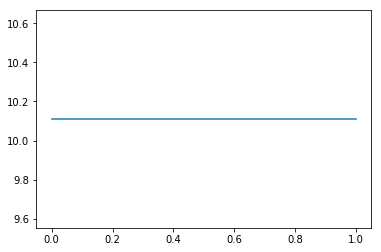

In [7]:
def train_nn(sess, epochs, batch_size, get_batches_fn, train_op, cross_entropy_loss, input_image,
             correct_label, keep_prob, learning_rate):
    """
    Train neural network and print out the loss during training.
    :param sess: TF Session
    :param epochs: Number of epochs
    :param batch_size: Batch size
    :param get_batches_fn: Function to get batches of training data.  Call using get_batches_fn(batch_size)
    :param train_op: TF Operation to train the neural network
    :param cross_entropy_loss: TF Tensor for the amount of loss
    :param input_image: TF Placeholder for input images
    :param correct_label: TF Placeholder for label images
    :param keep_prob: TF Placeholder for dropout keep probability
    :param learning_rate: TF Placeholder for learning rate
    """
    # TODO: Implement function
    sess.run(tf.global_variables_initializer())

    print('Starting training... for {} epochs'.format(epochs))
    print()
    for epoch in range(epochs):
        print('Epoch : {}'.format(epoch + 1))
        loss_log = []
        for image, label in get_batches_fn(batch_size):
            _, loss = sess.run([train_op, cross_entropy_loss],
                                feed_dict={
                                    input_image: image,
                                    correct_label: label,
                                    keep_prob: 0.5,
                                    learning_rate: 0.0009
                                })
            loss_log.append('{:3f}'.format(loss))
        print(loss_log)
        plt.plot(loss_log)
        print()
    print('Training finished')
    return None


tests.test_train_nn(train_nn)


In [8]:
def run():
    num_classes = 2
    image_shape = (160, 576)
    data_dir = './data'
    runs_dir = './runs'
    tests.test_for_kitti_dataset(data_dir)

    # Download pretrained vgg model
    helper.maybe_download_pretrained_vgg(data_dir)

    # OPTIONAL: Train and Inference on the cityscapes dataset instead of the Kitti dataset.
    # You'll need a GPU with at least 10 teraFLOPS to train on.
    #  https://www.cityscapes-dataset.com/

    with tf.Session() as sess:
        # Path to vgg model
        vgg_path = os.path.join(data_dir, 'vgg')
        # Create function to get batches
        get_batches_fn = helper.gen_batch_function(os.path.join(data_dir, 'data_road/training'), image_shape)

        # OPTIONAL: Augment Images for better results
        #  https://datascience.stackexchange.com/questions/5224/how-to-prepare-augment-images-for-neural-network

        # TODO: Build NN using load_vgg, layers, and optimize function
        # Placeholders
        correct_label = tf.placeholder(tf.int32, [None, None, None, num_classes], name='correct_label')
        learning_rate = tf.placeholder(tf.float32, name='learning_rate')

        # Getting layers from vgg.
        input_image, keep_prob, layer3_out, layer4_out, layer7_out = load_vgg(sess, vgg_path)

        # Creating new layers.
        layer_output = layers(layer3_out, layer4_out, layer7_out, num_classes)

        # Creating loss and optimizer operations.
        logits, train_op, cross_entropy_loss = optimize(layer_output, correct_label, learning_rate, num_classes)
        # TODO: Train NN using the train_nn function
        epochs = 40 # 6 12 24 
        batch_size = 16

        saver = tf.train.Saver()

        train_nn(sess, epochs, batch_size, get_batches_fn, train_op, cross_entropy_loss, input_image,
                 correct_label, keep_prob, learning_rate)
        
        # TODO: Save inference data using helper.save_inference_samples
        helper.save_inference_samples(runs_dir, data_dir, sess, image_shape, logits, keep_prob, input_image)
        #  helper.save_inference_samples(runs_dir, data_dir, sess, image_shape, logits, keep_prob, input_image)

        # OPTIONAL: Apply the trained model to a video

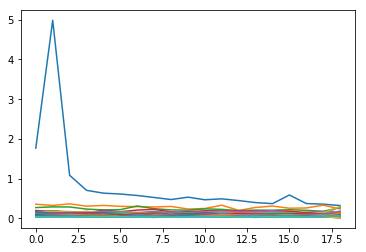

In [9]:
run()